In [1]:
% Path variables which are necessary
addpath([pwd filesep 'libsvm']);

% Some variables used to make pretty plots
col = [0.9047    0.1918    0.1988
    0.2941    0.5447    0.7494
    0.3718    0.7176    0.3612
    1.0000    0.5482    0.1000
    0.4550    0.4946    0.4722
    0.6859    0.4035    0.2412
    0.9718    0.5553    0.7741
    0.5313    0.3359    0.6523];

col = repmat(col,2,1);
col_fill = col;
col(9:end,:) = 0; % when plotting > 8 items, we make the outline black

marker = {'d','+','o','x','>','s','<','+','^'};
marker = repmat(marker,1,2);
ms = 12;
savefigflag=0;

In [2]:
svm_path = which('svmtrain');

fprintf('\n');
if strfind(lower(svm_path),'.mex') > 0
    fprintf('The path for svmtrain is: %s\n',svm_path);
    fprintf('libsvm is loaded properly! Carry on!\n');
else
    fprintf('Could not find LIBSVM. Make sure it''s added to the path.\n');
end

The path for svmtrain is: /home/alistairewj/mimic-workshop/mlcc/lab2-intro-ml/libsvm/svmtrain.mexa64
libsvm is loaded properly! Carry on!

```
% Option 1. This loads fisher iris instead of the ICU data
load fisheriris;
X = meas(:,1:3);
X_header = {'Sepal length','Sepal width','Petal length'};
y = double(strcmp(species,'virginica')==1);
clear meas species;
```

```
% Option 2. Extract the patient data using the query from your assignment
% Run the following to connect to the database

% STEP 1: Tell Matlab where the driver is
javaclasspath('sqlite-jdbc-3.8.11.2.jar') % use this for SQLite

% STEP 2: Connect to the Database
if exist('conn','var') != 1
conn = database('','','',...
    'org.sqlite.JDBC',['jdbc:sqlite:' pwd filesep 'data' filesep 'mimiciii_v1_3_demo.sqlite']);
end

% Option 2 (continued). Extract the patient data using the query from your assignment
% At the moment this query is long, and takes ~5 minutes
setdbprefs('DataReturnFormat','dataset')
query = makeQuery('mlcc1-problem-set-solutions.sql');
data = fetch(conn,query);

% now convert data to a cell array
data = dataset2cell(data);

% we can get the column names from the first row of the 'data' variable
header = data(1,:);
header{2} = 'OUTCOME';
header = regexprep(header,'_',''); % remove underscores
data = data(2:end,:);

% MATLAB sometimes reads 'null' instead of NaN
data(cellfun(@isstr, data) & cellfun(@(x) strcmp(x,'null'), data)) = {NaN};

% MATLAB sometimes has blank cells which should be NaN
data(cellfun(@isempty, data)) = {NaN};

% Convert the data into a matrix of numbers
% This is a MATLAB data type thing - we can't do math with cell arrays
data = cell2mat(data);

X = data(:,3:5);
X_header = header(3:5);
y = data(:,2);
```

In [3]:
% (Option 3) Load the ICU data from the .mat file provided

% Loads in 'X', 'X_header', and 'y' variables
load('MLCCData.mat'); 


idxData = ismember(header,{'Age','HeartRateMin','GCSMin'});

X = data(:,idxData);
X_header = header(idxData);
y = data(:,2);

X_header

X_header = 

    'Age'    'HeartRateMin'    'GCSMin'

In [4]:
% Data will have at least three columns: 
%   ICUSTAY_ID, OUTCOME, AGE

% the following loops display the data nicely
W = 5; % the maximum number of columns to print at one time
for o=1:floor(size(data,2)/W)
    idxColumn = (o-1)*W + 1 : o*W;
    if idxColumn(end) > size(data,2)
        idxColumn = idxColumn(1):size(data,2);
    end
    
    fprintf('%12s\t',header{idxColumn});
    fprintf('\n');
    for n=1:5
        for m=idxColumn
            fprintf('%12g\t',data(n, m));
        end
        fprintf('\n');
    end
    fprintf('\n');
end

ICUSTAYID	     OUTCOME	         Age	HeartRateMin	HeartRateMax	
      230834	           0	     23.6137	         111	         122	
      284549	           0	     86.7196	          59	          76	
      204985	           0	     74.2264	          70	          83	
      261097	           0	     51.3441	          91	          91	
      219258	           0	     51.4133	          58	         118	

   MeanBPMin	   MeanBPMax	 RespRateMin	 RespRateMax	      GCSMin	
          59	          64	          12	          22	          15	
          55	         108	          15	          25	          15	
     47.3333	          65	          12	          20	          15	
          87	          87	          19	          19	         NaN	
          59	     123.667	           9	          31	           8	

      GCSMax	BILIRUBINmin	BILIRUBINmax	CREATININEmin	CREATININEmax	
          15	         NaN	         NaN	         0.8	           1	
          15	         0.5	         0.5	         0.6	         0.7	
         

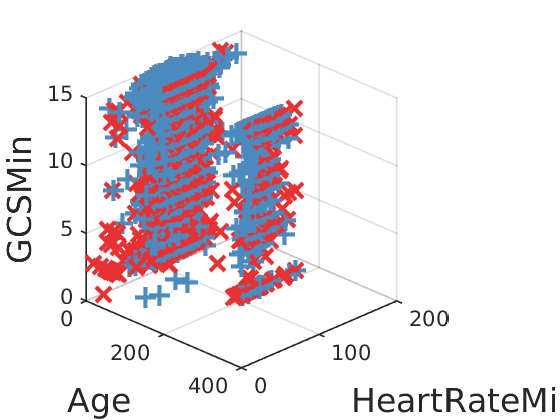

In [5]:
% Before we train a model - let's inspect the data
idxTarget = y == 1; % note: '=' defines a number, '==' compares two variables

figure(1); clf; hold all;

plot3(X(idxTarget,1),X(idxTarget,2),X(idxTarget,3),...
    'Linestyle','none','Marker','x',...
    'MarkerFaceColor',col(1,:),'MarkerEdgeColor',col(1,:)...
    ,'MarkerSize',10,'LineWidth',2);
plot3(X(~idxTarget,1),X(~idxTarget,2),X(~idxTarget,3),...
    'Linestyle','none','Marker','+',...
    'MarkerFaceColor',col(2,:),'MarkerEdgeColor',col(2,:)...
    ,'MarkerSize',10,'LineWidth',2);
grid on;

xlabel(X_header{1},'FontSize',16);
ylabel(X_header{2},'FontSize',16);
zlabel(X_header{3},'FontSize',16);

 % change the angle of the view to help inspection
set(gca,'view',[45 25]);

% 1) What do you see that is notable?
% ANSWER: for the ICU data...
%   there are ages ~ 300, these are de-identified ages

In [6]:
% Correct the erroneous ages
% Hint: the median age of patients > 89 is 91.6.
X( X(:,1) > 89, 1 ) = 91.6;

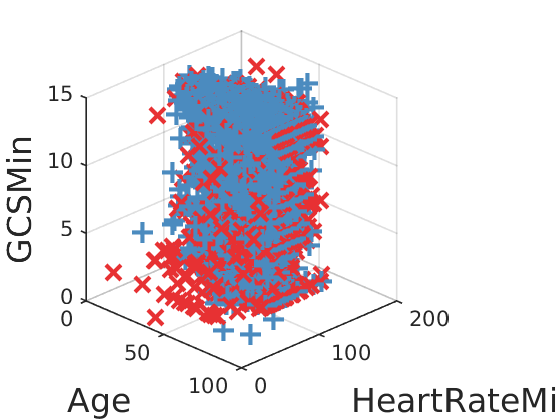

In [7]:
% Inspect the data correction
idxTarget = y == 1; % note: '=' defines a number, '==' compares two variables

figure(1); clf; hold all;

plot3(X(idxTarget,1),X(idxTarget,2),X(idxTarget,3),...
    'Linestyle','none','Marker','x',...
    'MarkerFaceColor',col(1,:),'MarkerEdgeColor',col(1,:)...
    ,'MarkerSize',10,'LineWidth',2);
plot3(X(~idxTarget,1),X(~idxTarget,2),X(~idxTarget,3),...
    'Linestyle','none','Marker','+',...
    'MarkerFaceColor',col(2,:),'MarkerEdgeColor',col(2,:)...
    ,'MarkerSize',10,'LineWidth',2);
grid on;

xlabel(X_header{1},'FontSize',16);
ylabel(X_header{2},'FontSize',16);
zlabel(X_header{3},'FontSize',16);

 % change the angle of the view to help inspection
set(gca,'view',[45 25]);

% 1) What do you see that is notable?
% ANSWER: for the ICU data...
%   patients with a minimum heart rate of 0 appear more likely to die
%   patients with "extreme" data (outside the massive blob in the middle) seem more likely to die

In [8]:
% Normalize the data!
% First get the column wise mean and the column wise standard deviation
mu = nanmean(X, 1);
sigma = nanstd(X, [], 1);

% Now subtract each element of mu from each column of X
X = bsxfun(@minus, X, mu);
X = bsxfun(@rdivide, X, sigma);

In [9]:
% We will be using libsvm. If you call svmtrain on its own, it lists the options available
svmtrain;

Usage: model = svmtrain(training_label_vector, training_instance_matrix, 'libsvm_options');
libsvm_options:
-s svm_type : set type of SVM (default 0)
	0 -- C-SVC		(multi-class classification)
	1 -- nu-SVC		(multi-class classification)
	2 -- one-class SVM
	3 -- epsilon-SVR	(regression)
	4 -- nu-SVR		(regression)
-t kernel_type : set type of kernel function (default 2)
	0 -- linear: u'*v
	1 -- polynomial: (gamma*u'*v + coef0)^degree
	2 -- radial basis function: exp(-gamma*|u-v|^2)
	3 -- sigmoid: tanh(gamma*u'*v + coef0)
	4 -- precomputed kernel (kernel values in training_instance_matrix)
-d degree : set degree in kernel function (default 3)
-g gamma : set gamma in kernel function (default 1/num_features)
-r coef0 : set coef0 in kernel function (default 0)
-c cost : set the parameter C of C-SVC, epsilon-SVR, and nu-SVR (default 1)
-n nu : set the parameter nu of nu-SVC, one-class SVM, and nu-SVR (default 0.5)
-p epsilon : set the epsilon in loss function of epsilon-SVR (default 0.1)
-m ca

In [10]:
% Using LIBSVM, train an SVM classifier with a linear kernel
model_linear = svmtrain(y, X, '-t 0');
% Atypically, LIBSVM receives options as a single string in the fourth input
% e.g. '-v 1 -b 1 -g 0.5 -c 1'

% Apply the classifier to the data set
pred = svmpredict(y, X, model_linear);

*
optimization finished, #iter = 1
nu = nan
obj = nan, rho = nan
nSV = 0, nBSV = 0
Total nSV = 0
Accuracy = 23.7494% (1524/6417) (classification)

We can interpret the above output. The code only ran for 1 iteration.
The objective function, "obj", is NaN.
We have 0 support vectors (nSV).

There's clearly a bug! What have we forgotten?

In [11]:
X(1:20,:)

ans =

   -2.9162    1.8213    0.9010
    1.0972   -0.9716    0.9010
    0.3026   -0.3808    0.9010
   -1.1526    0.7471       NaN
   -1.1482   -1.0253   -0.6094
   -1.1227    1.0156   -0.6094
    0.6375    0.1563   -1.6882
   -0.0080   -0.6494    0.6852
   -0.0054   -0.2197    0.9010
   -2.4675    1.0156       NaN
    0.3520   -1.1865    0.9010
    0.3905   -0.8105    0.6852
   -1.0092   -0.5957    0.0379
   -0.9954    2.3047    0.0379
   -0.9791   -0.2197    0.9010
   -0.9358    0.4248   -1.6882
   -1.4441    0.3711    0.9010
   -1.3662   -0.5420    0.9010
   -1.3657       NaN       NaN
   -1.2641   -0.2734   -0.1778

Looks like there is some missing data (not a number, or 'NaN') - when the code tries to do math with these missing values, it returns NaN. Imagine you try to calculate how far away NaN is from your current position - the result would be NaN. 

The SVM asks the question: "is this point above the hyperplane I'm learning or below the hyperplane I'm learning?". (Recall that a 'hyperplane' is just a high dimensional line). The idea is that we want all 'o' to be above the hyperplane and all 'x' to be below the hyperplane (i.e. we want to separate our data). But if we ask if 'NaN' is above or below the hyperplane, we just get 'NaN'. Then, when it sums across all points to see how many 'o' are above the plane, it also returns 'NaN'. This breaks the algorithm and it stops trying to optimize the separating plane.

In [12]:
% Make sure we impute a value for missing data, otherwise the models can't train
X( isnan(X) ) = 0;
% since we've normalized the data to have 0 mean, imputing 0 is equivalent to imputing the mean

In [13]:
X(1:20,:)

ans =

   -2.9162    1.8213    0.9010
    1.0972   -0.9716    0.9010
    0.3026   -0.3808    0.9010
   -1.1526    0.7471         0
   -1.1482   -1.0253   -0.6094
   -1.1227    1.0156   -0.6094
    0.6375    0.1563   -1.6882
   -0.0080   -0.6494    0.6852
   -0.0054   -0.2197    0.9010
   -2.4675    1.0156         0
    0.3520   -1.1865    0.9010
    0.3905   -0.8105    0.6852
   -1.0092   -0.5957    0.0379
   -0.9954    2.3047    0.0379
   -0.9791   -0.2197    0.9010
   -0.9358    0.4248   -1.6882
   -1.4441    0.3711    0.9010
   -1.3662   -0.5420    0.9010
   -1.3657         0         0
   -1.2641   -0.2734   -0.1778

Great, now let's try to find the hyperplane that best separates the data using our SVM.

In [14]:
% Using LIBSVM, train an SVM classifier with a linear kernel
model_linear = svmtrain(y, X, '-t 0');
% Atypically, LIBSVM receives options as a single string in the fourth input
% e.g. '-v 1 -b 1 -g 0.5 -c 1'

% Apply the classifier to the data set
pred = svmpredict(y, X, model_linear);

..
*
optimization finished, #iter = 2441
nu = 0.474988
obj = -3048.000037, rho = -1.000035
nSV = 3096, nBSV = 2969
Total nSV = 3096
Accuracy = 76.2506% (4893/6417) (classification)

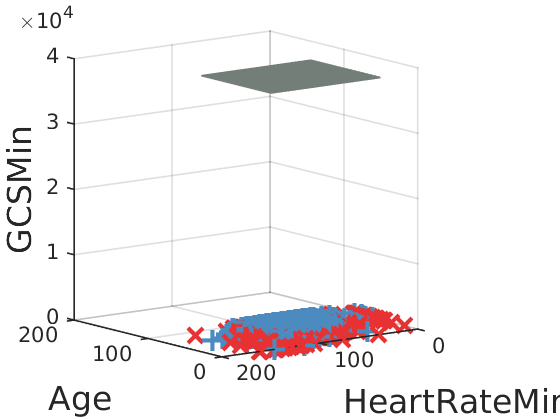

In [15]:
figure(1); clf; hold all;
idxTarget = y == 1; % note: '=' defines a number, '==' compares two variables

% We would like to plot the original data because it's in units we understand (e.g. age in years)
% we can un-normalize the data for plotting:
X_orig = bsxfun(@times, X, sigma);
X_orig = bsxfun(@plus, X_orig, mu);

plot3(X_orig(idxTarget,1),X_orig(idxTarget,2),X_orig(idxTarget,3),...
    'Linestyle','none','Marker','x',...
    'MarkerFaceColor',col(1,:),'MarkerEdgeColor',col(1,:),...
    'MarkerSize',10,'LineWidth',2);
plot3(X_orig(~idxTarget,1),X_orig(~idxTarget,2),X_orig(~idxTarget,3),...
    'Linestyle','none','Marker','+',...
    'MarkerFaceColor',col(2,:),'MarkerEdgeColor',col(2,:),...
    'MarkerSize',10,'LineWidth',2);
plot3(X_orig(pred==1,1),X_orig(pred==1,2),X_orig(pred==1,3),...
    'Linestyle','none','Marker','o',...
    'MarkerFaceColor','none','MarkerEdgeColor',col(1,:),...
    'MarkerSize',10,'LineWidth',2,...
    'HandleVisibility','off');
grid on;

xi = -3:0.25:3;
yi = -3:0.25:3;


% plot the hyperplane
w = model_linear.SVs' * model_linear.sv_coef;
b = model_linear.rho;
[XX,YY] = meshgrid(xi,yi);
ZZ=(b - w(1) * XX - w(2) * YY)/w(3);
XX = XX*sigma(1) + mu(1);
YY = YY*sigma(2) + mu(2);
ZZ = ZZ*sigma(3) + mu(3);
mesh(XX,YY,ZZ,'EdgeColor',col(5,:),'FaceColor','none');

%legend({'Died in hospital','Survived'},'FontSize',16);
xlabel(X_header{1},'FontSize',16);
ylabel(X_header{2},'FontSize',16);
zlabel(X_header{3},'FontSize',16);
set(gca,'view',[-127    10]);

There is a word for this separating hyperplane: bad. It's so far away from our data it simply classifies everything as 0, or 'below the hyperplane'. This is not a very useful classifier - it's simply predicting all patients will survive. The question is, why is this happening?

In [16]:
fprintf('Number of patients who die:  %g.\n',sum(y==1));
fprintf('Number of patients who live: %g.\n',sum(y==0));

Number of patients who die:  1524.
Number of patients who live: 4893.

The answer lies in the class balance: we have almost 3 times as many patients who live compared to patients who die. The optimization algorithm will never make a perfect boundary: it has to determine a balance between misclassifying patients who survive and misclassifying patients who die. The simplest solution is just to say everyone survives. How do we fix this?

A common approach in machine learning for the unbalanced class problem is to either:
1. Subsample the bigger class (i.e. only use 1524 of our 4893 surviving patients)
2. Upsample the smaller class (i.e. copy the 1524 non-surviving patients until we have 4893)

We will try the first approach.

In [17]:
N0 = sum(y==0);
N1 = sum(y==1);

% we randomly pick 0s so that we don't accidentally pick a biased subset
% for example, if X was sorted by age, we would only get young people by selecting the first N1 rows
% if you know X isn't sorted, then this is an excessive step
% still, it's safer to randomize the indices we select just incase!
rng(777,'twister'); % ensure we always get the same random numbers
[~,idxRandomize] = sort(rand(N0,1));

idxKeep = find(y==0); % find all the negative outcomes
idxKeep = idxKeep(idxRandomize(1:N1)); % pick a random N1 negative outcomes
idxKeep = [find(y==1);idxKeep]; % add in the positive outcomes
idxKeep = sort(idxKeep); % probably not needed but it's cleaner

In [18]:
X_train = X(idxKeep,:);
y_train = y(idxKeep);

In [19]:
% Using LIBSVM, train an SVM classifier with a linear kernel
model_linear = svmtrain(y_train, X_train, '-t 0');
% Atypically, LIBSVM receives options as a single string in the fourth input
% e.g. '-v 1 -b 1 -g 0.5 -c 1'

% Apply the classifier to the data set
% Note, we can apply the predictions to *all* the data, instead of just our training set
pred = svmpredict(y, X, model_linear);

....
**.
*
optimization finished, #iter = 4929
nu = 0.844887
obj = -2574.917447, rho = -0.303950
nSV = 2585, nBSV = 2566
Total nSV = 2585
Accuracy = 66.9783% (4298/6417) (classification)

Note: our accuracy has actually *decreased* from 76% to 66.9%. This is because our classifier is actually trying now: while this classifier may have lower accuracy, it may have better performance in metrics which more appropriately factor in the unbalanced classes.

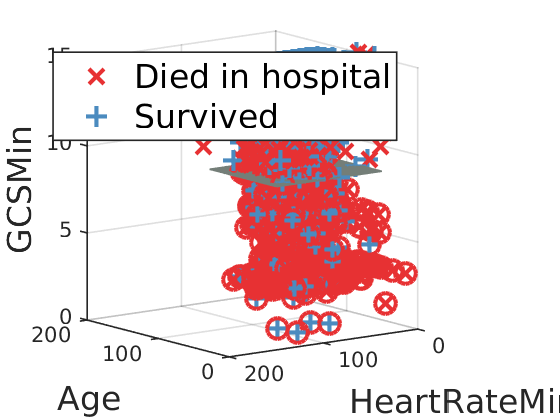

In [20]:
% Evaluate the model qualitatively

figure(1); clf; hold all;
idxTarget = y == 1; % note: '=' defines a number, '==' compares two variables

% We would like to plot the original data because it's in units we understand (e.g. age in years)
% we can un-normalize the data for plotting:
X_orig = bsxfun(@times, X, sigma);
X_orig = bsxfun(@plus, X_orig, mu);

plot3(X_orig(idxTarget,1),X_orig(idxTarget,2),X_orig(idxTarget,3),...
    'Linestyle','none','Marker','x',...
    'MarkerFaceColor',col(1,:),'MarkerEdgeColor',col(1,:),...
    'MarkerSize',10,'LineWidth',2);
plot3(X_orig(~idxTarget,1),X_orig(~idxTarget,2),X_orig(~idxTarget,3),...
    'Linestyle','none','Marker','+',...
    'MarkerFaceColor',col(2,:),'MarkerEdgeColor',col(2,:),...
    'MarkerSize',10,'LineWidth',2);
plot3(X_orig(pred==1,1),X_orig(pred==1,2),X_orig(pred==1,3),...
    'Linestyle','none','Marker','o',...
    'MarkerFaceColor','none','MarkerEdgeColor',col(1,:),...
    'MarkerSize',10,'LineWidth',2,...
    'HandleVisibility','off');
grid on;

xi = -3:0.25:3;
yi = -3:0.25:3;


% plot the hyperplane
w = model_linear.SVs' * model_linear.sv_coef;
b = model_linear.rho;
[XX,YY] = meshgrid(xi,yi);
ZZ=(b - w(1) * XX - w(2) * YY)/w(3);
XX = XX*sigma(1) + mu(1);
YY = YY*sigma(2) + mu(2);
ZZ = ZZ*sigma(3) + mu(3);
mesh(XX,YY,ZZ,'EdgeColor',col(5,:),'FaceColor','none');

legend({'Died in hospital','Survived'},'FontSize',16);
xlabel(X_header{1},'FontSize',16);
ylabel(X_header{2},'FontSize',16);
zlabel(X_header{3},'FontSize',16);
set(gca,'view',[-127    10]);

Much better! The hyperplane has picked somewhere in the middle of GCS to separate the data. GCS stands for Glasgow Coma Scale: it is a measure of a patient's neurological status. A value of 3 is equivalent to a coma, and a value of 15 is equivalent to normal neurological function. Our classifier has learned this, and now predicts that patients in a coma are more likely to die.

In [21]:
% Evaluate the model quantitatively

% First, we calculate the four "operating point" statistics
TP = sum( pred == 1 & y == 1 );
FP = sum( pred == 0 & y == 1 );

TN = sum( pred == 0 & y == 0 );
FN = sum( pred == 1 & y == 0 );

% Now we create the confusion matrix

cm = [TP, FP;
    TN, FN]

cm =

         668         856
        3630        1263

In [22]:
% We can also create the sensitivity/specificity measures

fprintf('\n');
fprintf('Sensitivity: %6.2f%%\n', 100 * TP / (TP+FN));
fprintf('Specificity: %6.2f%%\n', 100 * TN / (TN+FP));
fprintf('PPV: %6.2f%%\n', 100 * TP / (TP + FP));
fprintf('NPV: %6.2f%%\n', 100 * TN / (TN+FN));

fprintf('\n');

% all together

fprintf('%6g\t%6g\t%10.2f%% \n', cm(1,1), cm(1,2), 100 * TP / (TP + FP));
fprintf('%6g\t%6g\t%10.2f%% \n', cm(2,1), cm(2,2), 100 * TN / (TN+FN));
fprintf('%5.2f%%\t%5.2f%%\t%10.2f%% \n', 100 * TP / (TP+FN), 100 * TN / (TN+FP), 100 * (TP+TN)/(TP+TN+FP+FN));

Sensitivity:  34.59%
Specificity:  80.92%
PPV:  43.83%
NPV:  74.19%

   668	   856	     43.83% 
  3630	  1263	     74.19% 
34.59%	80.92%	     66.98%

For patients who die, our model detects 34.59% of them. Not the most sensitive of classifiers.

Furthermore, for patients who our model predicts to die, only 43.83% actually die. Which means that if our model predicts a patient to die, they are actually more likely to *live* than die. This may sound paradoxical at first but it is what the PPV tells us. However, patients who our model predicts to die are *more likely* to die than patients who our model predicts to live. How do I know this? We can calculate it:

In [23]:
%out.PositiveLR=(1-out.sens)/out.spec;

% what is the probability that we predict survival given the patient died?
% this is simply 1 - sensitivity
% recall sensitivity is "given the patient died, what is the probability we predicted death?"
% so 1 - sensitivity is "given the patient died, what is the probability we predicted survival?"
%1 - (TP / (TP+FP)) 

% what is the probability the patient survives given we predicted survival?
% this is the specificity

% so what are the odds the patient dies, given we predicted they survived


In [24]:
% Now let's try with an RBF kernel
% This is LIBSVM's most flexible kernel
% We specify it as '-t 2'

% train the model
model_rbf = svmtrain(y_train, X_train, '-t 2');

% Apply the classifier to the data set
[pred,acc,prob] = svmpredict(y, X, model_rbf);

..
*.
*
optimization finished, #iter = 3646
nu = 0.769790
obj = -2321.227382, rho = 0.615785
nSV = 2387, nBSV = 2311
Total nSV = 2387
Accuracy = 64.3447% (4129/6417) (classification)

In [25]:
[pred(1:20),prob(1:20)]

ans =

         0    0.6958
         0    1.0040
         0    1.0056
         0    0.4056
         0    0.1522
    1.0000   -0.6223
    1.0000   -0.9111
         0    1.1499
         0    1.0055
    1.0000   -0.3219
         0    1.0037
         0    1.0863
         0    1.2125
    1.0000   -1.1526
         0    0.9661
    1.0000   -0.9935
         0    1.0193
         0    1.0117
         0    0.9479
         0    0.9232

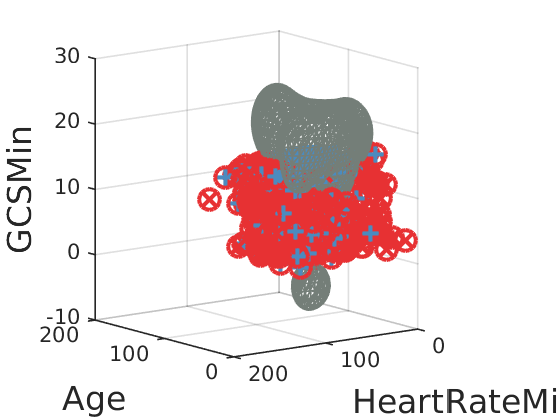

In [26]:
X_orig = bsxfun(@times, X, sigma);
X_orig = bsxfun(@plus, X_orig, mu);

% plot the model and the data
figure(1); clf; hold all;
idxTarget = y == 1; % note: '=' defines a number, '==' compares two variables

plot3(X_orig(idxTarget,1),X_orig(idxTarget,2),X_orig(idxTarget,3),...
    'Linestyle','none','Marker','x',...
    'MarkerFaceColor',col(1,:),'MarkerEdgeColor',col(1,:),...
    'MarkerSize',10,'LineWidth',2);
plot3(X_orig(~idxTarget,1),X_orig(~idxTarget,2),X_orig(~idxTarget,3),...
    'Linestyle','none','Marker','+',...
    'MarkerFaceColor',col(2,:),'MarkerEdgeColor',col(2,:),...
    'MarkerSize',10,'LineWidth',2);
plot3(X_orig(pred==1,1),X_orig(pred==1,2),X_orig(pred==1,3),...
    'Linestyle','none','Marker','o',...
    'MarkerFaceColor','none','MarkerEdgeColor',col(1,:),...
    'MarkerSize',10,'LineWidth',2,...
    'HandleVisibility','off');
grid on;

% reapply the SVM to a grid of all possible values
xi=-5:0.25:5;
yi=-5:0.25:5;
zi=-5:0.25:5;
[XX,YY,ZZ] = meshgrid(xi,yi,zi);
tmpdat = [XX(:),YY(:),ZZ(:)];
[grid_pred,grid_acc,VV] = svmpredict(zeros(size(tmpdat,1),1), tmpdat, model_rbf, '-q');
VV = reshape(VV,length(yi),length(xi),length(zi));
XX = XX*sigma(1) + mu(1);
YY = YY*sigma(2) + mu(2);
ZZ = ZZ*sigma(3) + mu(3);

% plot the new hyperplane
h3=patch(isosurface(XX,YY,ZZ,VV,0)); 
set(h3,'facecolor','none','edgecolor',col(5,:));

% standard info for the plot
%legend({'Died in hospital','Survived'},'FontSize',16);
xlabel(X_header{1},'FontSize',16);
ylabel(X_header{2},'FontSize',16);
zlabel(X_header{3},'FontSize',16);
set(gca,'view',[-127    10]);

We see this hyperplane is a lot more flexible. It can be hard to interpret what's above and what's below - we can add in another isosurface which is much "closer" to what the SVM believes to be patients who died.

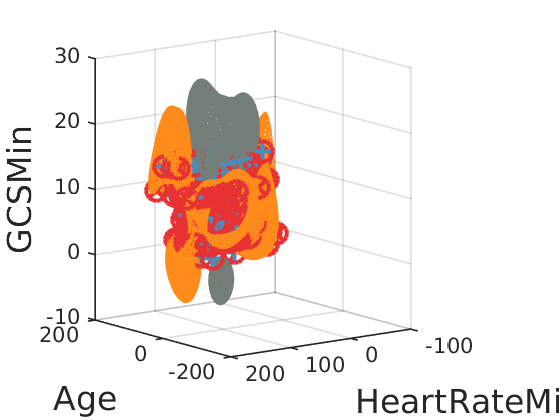

In [27]:
X_orig = bsxfun(@times, X, sigma);
X_orig = bsxfun(@plus, X_orig, mu);

% plot the model and the data
figure(1); clf; hold all;
idxTarget = y == 1; % note: '=' defines a number, '==' compares two variables

plot3(X_orig(idxTarget,1),X_orig(idxTarget,2),X_orig(idxTarget,3),...
    'Linestyle','none','Marker','x',...
    'MarkerFaceColor',col(1,:),'MarkerEdgeColor',col(1,:),...
    'MarkerSize',10,'LineWidth',2);
plot3(X_orig(~idxTarget,1),X_orig(~idxTarget,2),X_orig(~idxTarget,3),...
    'Linestyle','none','Marker','+',...
    'MarkerFaceColor',col(2,:),'MarkerEdgeColor',col(2,:),...
    'MarkerSize',10,'LineWidth',2);
plot3(X_orig(pred==1,1),X_orig(pred==1,2),X_orig(pred==1,3),...
    'Linestyle','none','Marker','o',...
    'MarkerFaceColor','none','MarkerEdgeColor',col(1,:),...
    'MarkerSize',10,'LineWidth',2,...
    'HandleVisibility','off');
grid on;

% reapply the SVM to a grid of all possible values
xi=-5:0.25:5;
yi=-5:0.25:5;
zi=-5:0.25:5;
[XX,YY,ZZ] = meshgrid(xi,yi,zi);
tmpdat = [XX(:),YY(:),ZZ(:)];
[grid_pred,grid_acc,VV] = svmpredict(zeros(size(tmpdat,1),1), tmpdat, model_rbf, '-q');
VV = reshape(VV,length(yi),length(xi),length(zi));
XX = XX*sigma(1) + mu(1);
YY = YY*sigma(2) + mu(2);
ZZ = ZZ*sigma(3) + mu(3);

% plot the hyperplane
h3=patch(isosurface(XX,YY,ZZ,VV,0)); 
set(h3,'facecolor','none','edgecolor',col(5,:));

% plot the hyperplane closer to positive outcomes
% note the SVM is treating positive outcomes as "below" the hyperplane, which is why we look for -1
h3=patch(isosurface(XX,YY,ZZ,VV,-1)); 
set(h3,'facecolor','none','edgecolor',col(4,:));

% standard info for the plot
%legend({'Died in hospital','Survived'},'FontSize',16);
xlabel(X_header{1},'FontSize',16);
ylabel(X_header{2},'FontSize',16);
zlabel(X_header{3},'FontSize',16);
set(gca,'view',[-127    10]);

In [28]:
% Evaluate the model

% First, we calculate the four "operating point" statistics
TP = sum( pred == 1 & y == 1 );
FP = sum( pred == 0 & y == 1 );

TN = sum( pred == 0 & y == 0 );
FN = sum( pred == 1 & y == 0 );

% Now we create the confusion matrix

cm = [TP, FP;
    FN, TN]

cm =

         930         594
        1694        3199

In [29]:
% We can also create the sensitivity/specificity measures

fprintf('\n');
fprintf('Sensitivity: %6.2f%%\n', 100 * TP / (TP+FN));
fprintf('Specificity: %6.2f%%\n', 100 * TN / (TN+FP));
fprintf('PPV: %6.2f%%\n', 100 * TP / (TP + FP));
fprintf('NPV: %6.2f%%\n', 100 * TN / (TN+FN));

fprintf('\n');

% all together

fprintf('%6g\t%6g\t%10.2f%% \n', cm(1,1), cm(1,2), 100 * TP / (TP + FP));
fprintf('%6g\t%6g\t%10.2f%% \n', cm(2,1), cm(2,2), 100 * TN / (TN+FN));
fprintf('%5.2f%%\t%5.2f%%\t%10.2f%% \n', 100 * TP / (TP+FN), 100 * TN / (TN+FP), 100 * (TP+TN)/(TP+TN+FP+FN));

Sensitivity:  35.44%
Specificity:  84.34%
PPV:  61.02%
NPV:  65.38%

   930	   594	     61.02% 
  1694	  3199	     65.38% 
35.44%	84.34%	     64.34%

In [30]:
% Directly compare the RBF model with the linear model

pred_linear = svmpredict(y, X, model_linear, '-q');
pred_rbf = svmpredict(y, X, model_rbf, '-q');

TP_l = sum( pred_linear == 1 & y == 1 );
FP_l = sum( pred_linear == 0 & y == 1 );
TN_l = sum( pred_linear == 0 & y == 0 );
FN_l = sum( pred_linear == 1 & y == 0 );

TP_r = sum( pred_rbf == 1 & y == 1 );
FP_r = sum( pred_rbf == 0 & y == 1 );
TN_r = sum( pred_rbf == 0 & y == 0 );
FN_r = sum( pred_rbf == 1 & y == 0 );

fprintf('Linear\tRBF\n');
fprintf('%4.2f%%\t%4.2f%%\tAccuracy\n', 100 * (TP_l+TN_l) / (TP_l+FN_l+TN_l+FP_l), 100 * (TP_r+TN_r) / (TP_r+FN_r+TN_r+FP_r));
fprintf('%4.2f%%\t%4.2f%%\tSensitivity\n', 100 * TP_l / (TP_l+FN_l), 100 * TP_r / (TP_r+FN_r));
fprintf('%6.2f%%\t%4.2f%%\tSpecificity\n', 100 * TN_l / (TN_l+FP_l), 100 * TN_r / (TN_r+FP_r));
fprintf('%6.2f%%\t%4.2f%%\tPPV\n', 100 * TP_l / (TP_l + FP_l), 100 * TP_r / (TP_r + FP_r));
fprintf('%6.2f%%\t%4.2f%%\tNPV\n', 100 * TN_l / (TN_l+FN_l), 100 * TN_r / (TN_r+FN_r));

Linear	RBF
66.98%	64.34%	Accuracy
34.59%	35.44%	Sensitivity
 80.92%	84.34%	Specificity
 43.83%	61.02%	PPV
 74.19%	65.38%	NPV

It's hard to tell which is better - RBF has higher sensitivity, specificity, PPV, but lower accuracy and NPV. Of course, we have to remember that accuracy is still not the best measure due to the imbalanced class problem. Let's look at the area under the receiver operator characteristic curve (AUROC). This is a useful measure which summarizes the operating point statistics over all operating points.

In [31]:
N_POS = sum(y==1);
N_NEG = sum(y==0);

[pred_linear,~,dist_linear] = svmpredict(y, X, model_linear, '-q');
[pred_rbf,~,dist_rbf] = svmpredict(y, X, model_rbf, '-q');

% ensure that dist_linear is positive for positive outcomes
idxTemp = find(pred_linear==1,1);
if dist_linear(idxTemp) < 0
    dist_linear = -dist_linear;
end

idxTemp = find(pred_rbf==1,1);
if dist_rbf(idxTemp) < 0
    dist_rbf = -dist_rbf;
end

[dist_rbf,idxSort] = sort(dist_rbf,1,'ascend');
y_rbf=y(idxSort);

idxNegative = y_rbf==0;
%=== Count the number of negative targets below each element
auc_rbf = cumsum(idxNegative,1);
%=== Only get positive targets
auc_rbf = auc_rbf(~idxNegative);
auc_rbf = sum(auc_rbf,1); %=== count number who are negative
auc_rbf = auc_rbf./(N_POS * N_NEG);


[dist_linear,idxSort] = sort(dist_linear,1,'ascend');
y_linear=y(idxSort);

idxNegative = y_linear==0;
%=== Count the number of negative targets below each element
auc_linear = cumsum(idxNegative,1);
%=== Only get positive targets
auc_linear = auc_linear(~idxNegative);
auc_linear = sum(auc_linear,1); %=== count number who are negative
auc_linear = auc_linear./(N_POS * N_NEG);



[auc_rbf, auc_linear]

ans =

    0.6695    0.6302

Looks like the AUROC for our RBF classifier is better! It's also nice to look at the ROC curve graphically, which helps interpret the value.

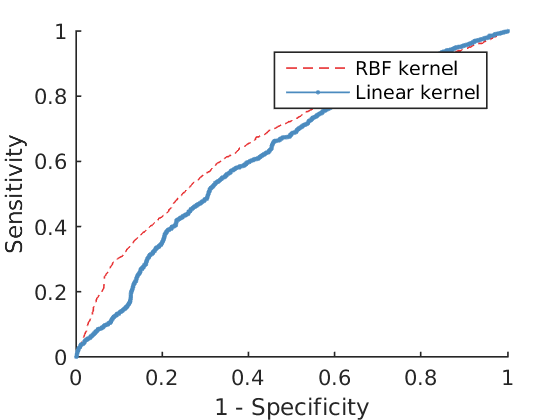

In [32]:
% Plot the RBF model and the linear model together
TP = flipud(y_rbf);
FP = cumsum(1-TP);
FP = flipud(FP);
TP = cumsum(TP);
TP = flipud(TP);
FN = cumsum(y_rbf)-y_rbf;
TN = numel(y_rbf) - TP - FP - FN;

TP_l = flipud(y_linear);
FP_l = cumsum(1-TP_l);
FP_l = flipud(FP_l);
TP_l = cumsum(TP_l);
TP_l = flipud(TP_l);
FN_l = cumsum(y_linear)-y_linear;
TN_l = numel(y_linear) - TP_l - FP_l - FN_l;

%=== Sensitivity (true positive rate)
roc_l_y = TP_l ./ (TP_l + FN_l);
%=== 1-Specificity (false positive rate)
roc_l_x = 1- (TN_l ./ (TN_l + FP_l));

TP_r = flipud(y_rbf);
FP_r = cumsum(1-TP_r);
FP_r = flipud(FP_r);
TP_r = cumsum(TP_r);
TP_r = flipud(TP_r);
FN_r = cumsum(y_rbf)-y_rbf;
TN_r = numel(y_rbf) - TP_r - FP_r - FN_r;

%=== Sensitivity (true positive rate)
roc_r_y = TP_r ./ (TP_r + FN_r);
%=== 1-Specificity (false positive rate)
roc_r_x = 1- (TN_r ./ (TN_r + FP_r));


figure(1); clf; hold all;
plot(roc_r_x, roc_r_y, '--','Color',col(1,:));
plot(roc_l_x, roc_l_y, '.-','Color',col(2,:));

legend('RBF kernel','Linear kernel');
xlabel('1 - Specificity');
ylabel('Sensitivity');

In [33]:
% Specify parameters in the RBF kernel
% The RBF kernel has some parameters of its own: gamma and capacity
% Let's set these to a different value then their defaults

gamma = 2;
capacity = 1;

% train the model
model_rbf_param = svmtrain(y, X, ['-t 2 -c ' num2str(2^(capacity)) ' -g ' num2str(2^(gamma))]);
[pred_rbf_param,~,dist_rbf_param] = svmpredict(y, X, model_rbf_param);

..............
*.............................................*.
*
optimization finished, #iter = 60327
nu = 0.439447
obj = -5393.333186, rho = -0.216561
nSV = 3667, nBSV = 2276
Total nSV = 3667
Accuracy = 80.4426% (5162/6417) (classification)

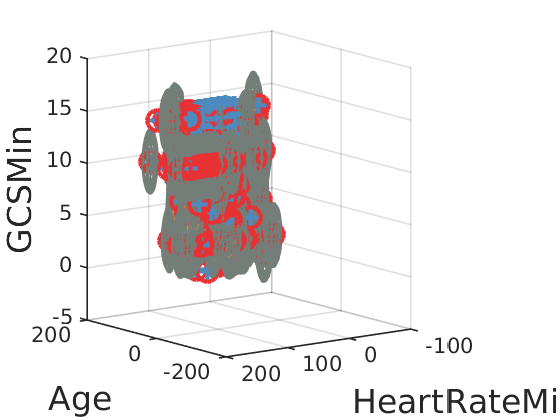

In [34]:
X_orig = bsxfun(@times, X, sigma);
X_orig = bsxfun(@plus, X_orig, mu);

% plot the model and the data
figure(1); clf; hold all;
idxTarget = y == 1; % note: '=' defines a number, '==' compares two variables

plot3(X_orig(idxTarget,1),X_orig(idxTarget,2),X_orig(idxTarget,3),...
    'Linestyle','none','Marker','x',...
    'MarkerFaceColor',col(1,:),'MarkerEdgeColor',col(1,:),...
    'MarkerSize',10,'LineWidth',2);
plot3(X_orig(~idxTarget,1),X_orig(~idxTarget,2),X_orig(~idxTarget,3),...
    'Linestyle','none','Marker','+',...
    'MarkerFaceColor',col(2,:),'MarkerEdgeColor',col(2,:),...
    'MarkerSize',10,'LineWidth',2);
plot3(X_orig(pred==1,1),X_orig(pred==1,2),X_orig(pred==1,3),...
    'Linestyle','none','Marker','o',...
    'MarkerFaceColor','none','MarkerEdgeColor',col(1,:),...
    'MarkerSize',10,'LineWidth',2,...
    'HandleVisibility','off');
grid on;

% reapply the SVM to a grid of all possible values
xi=-5:0.25:5;
yi=-5:0.25:5;
zi=-5:0.25:5;
[XX,YY,ZZ] = meshgrid(xi,yi,zi);
tmpdat = [XX(:),YY(:),ZZ(:)];
[grid_pred,grid_acc,VV] = svmpredict(zeros(size(tmpdat,1),1), tmpdat, model_rbf_param, '-q');
VV = reshape(VV,length(yi),length(xi),length(zi));
XX = XX*sigma(1) + mu(1);
YY = YY*sigma(2) + mu(2);
ZZ = ZZ*sigma(3) + mu(3);

% plot the hyperplane
h3=patch(isosurface(XX,YY,ZZ,VV,0)); 
set(h3,'facecolor','none','edgecolor',col(5,:));

% plot the hyperplane closer to positive outcomes
% note the SVM is treating positive outcomes as "below" the hyperplane, which is why we look for -1
h3=patch(isosurface(XX,YY,ZZ,VV,-1)); 
set(h3,'facecolor','none','edgecolor',col(4,:));

% standard info for the plot
%legend({'Died in hospital','Survived'},'FontSize',16);
xlabel(X_header{1},'FontSize',16);
ylabel(X_header{2},'FontSize',16);
zlabel(X_header{3},'FontSize',16);
set(gca,'view',[-127    10]);

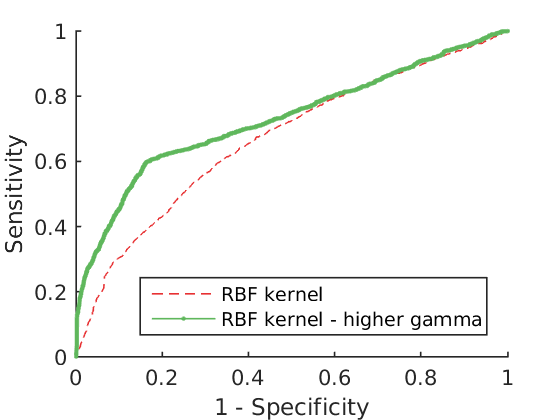

auc_rbf =

    0.6695


auc_rbf_param =

    0.7301

In [35]:
[pred_rbf_param,~,dist_rbf_param] = svmpredict(y, X, model_rbf_param, '-q');
idxTemp = find(pred_rbf_param==1,1);
if dist_rbf_param(idxTemp) < 0
    dist_rbf_param = -dist_rbf_param;
end

[dist_rbf_param,idxSort] = sort(dist_rbf_param,1,'ascend');
y_rbf_param=y(idxSort);

idxNegative = y_rbf_param == 0;
%=== Count the number of negative targets below each element
auc_rbf_param = cumsum(idxNegative,1);
%=== Only get positive targets
auc_rbf_param = auc_rbf_param(~idxNegative);
auc_rbf_param = sum(auc_rbf_param,1); %=== count number who are negative
auc_rbf_param = auc_rbf_param./(N_POS * N_NEG);

% also plot the figure
TP_r = flipud(y_rbf_param);
FP_r = cumsum(1-TP_r);
FP_r = flipud(FP_r);
TP_r = cumsum(TP_r);
TP_r = flipud(TP_r);
FN_r = cumsum(y_rbf_param)-y_rbf_param;
TN_r = numel(y_rbf_param) - TP_r - FP_r - FN_r;

%=== Sensitivity (true positive rate)
roc_rp_y = TP_r ./ (TP_r + FN_r);
%=== 1-Specificity (false positive rate)
roc_rp_x = 1- (TN_r ./ (TN_r + FP_r));


figure(1); clf; hold all;
plot(roc_r_x, roc_r_y, '--','Color',col(1,:));
plot(roc_rp_x, roc_rp_y, '.-','Color',col(3,:));

legend('RBF kernel','RBF kernel - higher gamma','Location','SouthEast');
xlabel('1 - Specificity');
ylabel('Sensitivity');


auc_rbf

auc_rbf_param

Great! Our parameter tweaking has improved the AUROC.

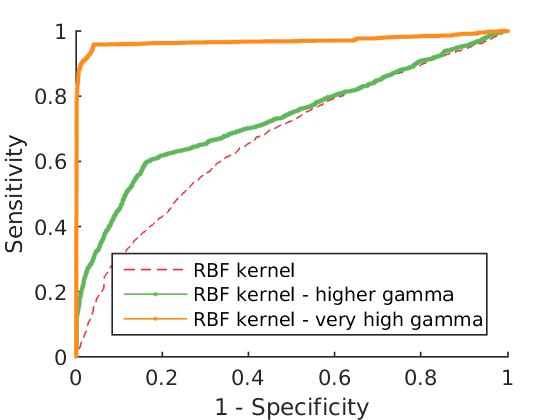

........*....*.*
optimization finished, #iter = 12142
nu = 0.381527
obj = -2997.420450, rho = -0.508657
nSV = 5845, nBSV = 570
Total nSV = 5845
Accuracy = 95.8548% (6151/6417) (classification)

In [36]:
% Optimize the RBF kernel
% Let's see how much better we can make our model!
% change gamma below to try and improve your performance
% Keep it as an integer!

gamma = 10;
capacity = 1;

%% train the model
model_rbf_opt = svmtrain(y, X, ['-t 2 -c ' num2str(2^(capacity)) ' -g ' num2str(2^(gamma))]);
[pred_rbf_opt,~,dist_rbf_opt] = svmpredict(y, X, model_rbf_opt);


idxTemp = find(pred_rbf_param==1,1);
if dist_rbf_opt(idxTemp) < 0
    dist_rbf_opt = -dist_rbf_opt;
end

[dist_rbf_opt,idxSort] = sort(dist_rbf_opt,1,'ascend');
y_rbf = y(idxSort);

idxNegative = y_rbf == 0;
%=== Count the number of negative targets below each element
auc_rbf_opt = cumsum(idxNegative,1);
%=== Only get positive targets
auc_rbf_opt = auc_rbf_opt(~idxNegative);
auc_rbf_opt = sum(auc_rbf_opt,1); %=== count number who are negative
auc_rbf_opt = auc_rbf_opt./(N_POS * N_NEG);

% also plot the figure
TP_r = flipud(y_rbf);
FP_r = cumsum(1-TP_r);
FP_r = flipud(FP_r);
TP_r = cumsum(TP_r);
TP_r = flipud(TP_r);
FN_r = cumsum(y_rbf)-y_rbf;
TN_r = numel(y_rbf) - TP_r - FP_r - FN_r;

%=== Sensitivity (true positive rate)
roc_ro_y = TP_r ./ (TP_r + FN_r);
%=== 1-Specificity (false positive rate)
roc_ro_x = 1- (TN_r ./ (TN_r + FP_r));


figure(1); clf; hold all;
plot(roc_r_x, roc_r_y, '--','Color',col(1,:));
plot(roc_rp_x, roc_rp_y, '.-','Color',col(3,:));
plot(roc_ro_x, roc_ro_y, '.-','Color',col(4,:));

legend('RBF kernel','RBF kernel - higher gamma','RBF kernel - very high gamma', 'Location','SouthEast');
xlabel('1 - Specificity');
ylabel('Sensitivity');

Almost perfect AUROC! Awesome! Have we solved mortality prediction?

In [37]:
dist_rbf_opt(1:20)

ans =

   -1.6492
   -1.6216
   -1.6166
   -1.4937
   -1.3976
   -1.3868
   -1.3844
   -1.3802
   -1.3789
   -1.3746
   -1.3703
   -1.3590
   -1.3498
   -1.3241
   -1.3110
   -1.3058
   -1.3018
   -1.2967
   -1.2934
   -1.2844

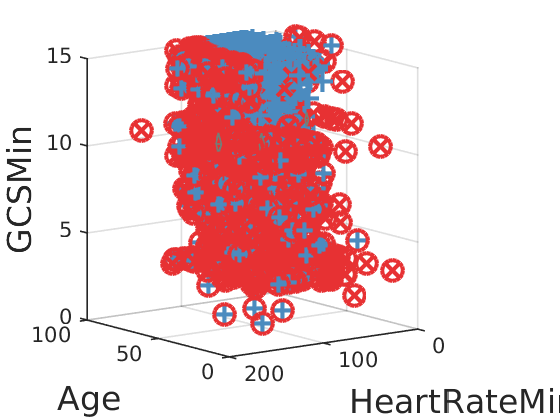

In [ ]:
X_orig = bsxfun(@times, X, sigma);
X_orig = bsxfun(@plus, X_orig, mu);

% plot the model and the data
figure(1); clf; hold all;
idxTarget = y == 1; % note: '=' defines a number, '==' compares two variables

plot3(X_orig(idxTarget,1),X_orig(idxTarget,2),X_orig(idxTarget,3),...
    'Linestyle','none','Marker','x',...
    'MarkerFaceColor',col(1,:),'MarkerEdgeColor',col(1,:),...
    'MarkerSize',10,'LineWidth',2);
plot3(X_orig(~idxTarget,1),X_orig(~idxTarget,2),X_orig(~idxTarget,3),...
    'Linestyle','none','Marker','+',...
    'MarkerFaceColor',col(2,:),'MarkerEdgeColor',col(2,:),...
    'MarkerSize',10,'LineWidth',2);
plot3(X_orig(pred==1,1),X_orig(pred==1,2),X_orig(pred==1,3),...
    'Linestyle','none','Marker','o',...
    'MarkerFaceColor','none','MarkerEdgeColor',col(1,:),...
    'MarkerSize',10,'LineWidth',2,...
    'HandleVisibility','off');
grid on;

% reapply the SVM to a grid of all possible values
xi=-5:0.25:5;
yi=-5:0.25:5;
zi=-5:0.25:5;
[XX,YY,ZZ] = meshgrid(xi,yi,zi);
tmpdat = [XX(:),YY(:),ZZ(:)];
[grid_pred,grid_acc,VV] = svmpredict(zeros(size(tmpdat,1),1), tmpdat, model_rbf_opt, '-q');
VV = reshape(VV,length(yi),length(xi),length(zi));
XX = XX*sigma(1) + mu(1);
YY = YY*sigma(2) + mu(2);
ZZ = ZZ*sigma(3) + mu(3);

% plot the hyperplane
h3=patch(isosurface(XX,YY,ZZ,VV,0)); 
set(h3,'facecolor','none','edgecolor',col(5,:));

% plot the hyperplane closer to positive outcomes
% note the SVM is treating positive outcomes as "below" the hyperplane, which is why we look for -1
h3=patch(isosurface(XX,YY,ZZ,VV,-1)); 
set(h3,'facecolor','none','edgecolor',col(4,:));

% standard info for the plot
%legend({'Died in hospital','Survived'},'FontSize',16);
xlabel(X_header{1},'FontSize',16);
ylabel(X_header{2},'FontSize',16);
zlabel(X_header{3},'FontSize',16);
%set(gca,'XLim',[50,70],'YLim',[100,120],'ZLim',[0,5]);
set(gca,'view',[-127    10]);
